In [192]:
import igraph
import elpigraph
import numpy as np
import os
from os import path

import seaborn as sns

from importlib import reload  
import clintraj_eltree
import clintraj_util
import clintraj_ml
reload(clintraj_eltree)
reload(clintraj_util)
reload(clintraj_ml)

from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime
from clintraj_eltree import project_on_tree,visualize_eltree_with_data,partition_data_by_tree_branches,prune_the_tree
from clintraj_eltree import ExtendLeaves_modified,regression_of_variable_with_trajectories, draw_pseudotime_dependence
from clintraj_util import associate_with_categorical_var, get_matrix_of_association_scores, get_standard_color_seq
from clintraj_qi import detect_variable_type

from clintraj_ml import apply_panel_of_manifold_learning_methods

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [193]:
# Loading data
file = 'data/infarction/all_dummies_q_imp_SVDcomplete.txt'
color_file = 'data/infarction/classes_sequence.txt'

df = pd.read_csv(file,delimiter='\t')
variable_names = [str(s) for s in df.columns[1:]]
X = df[df.columns[1:]].to_numpy()
X_original = X

with open(color_file) as fid:
    lines = fid.readlines()
color = np.ones(len(lines),'int32')
for i,line in enumerate(lines):
    color[i]=int(line.strip('\n'))

Shape of the data matrix: (1574, 123)


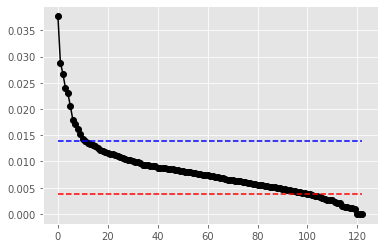

In [25]:
# Pre-processing the data
initial_dimension = 12

X = X[:,np.where(np.std(X,axis=0)>0)[0]]
X = scipy.stats.zscore(X)
print('Shape of the data matrix:',X.shape)

pca = PCA(n_components=X.shape[1],svd_solver='full')
Y = pca.fit_transform(X)
s = pca.explained_variance_ratio_
v = pca.components_.T
mean_val = np.mean(X,axis=0)
plt.plot(s,'ko-')
plt.plot([0,X.shape[1]-1],[s[0]/10,s[0]/10],'r--')
plt.plot([0,X.shape[1]-1],[s[initial_dimension-1],s[initial_dimension-1]],'b--')

X = Y[:,0:initial_dimension]

# this is for applying ELMAP in MATLAB
ElMapFolder = '/mnt/c/MyPrograms/__github/ElMap'
if os.path.exists(ElMapFolder+'/tests/'):
    np.savetxt(ElMapFolder+'/tests/'+'_input.txt', X, delimiter="\t")

variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=False)

# Definition of classes, depends on the nature of complications. Major class - black - corresponds to no complications case

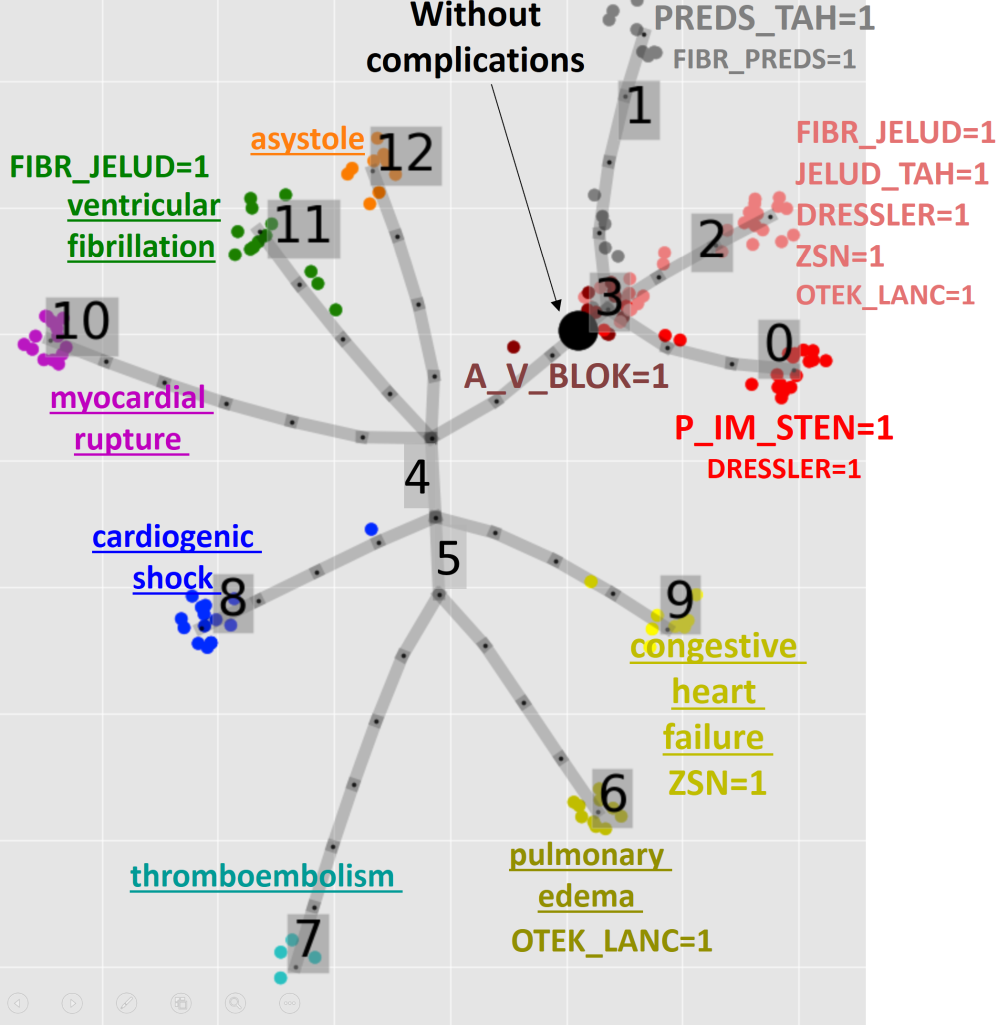

In [26]:
# Changing class colors for visualization

if True:
    clrs = []
    for c in color:
        if c==-1:
            clrs.append('k')
        if c==0:
            clrs.append('r')
        if c==1:
            clrs.append('tab:gray')
        if c==2:
            clrs.append('lightcoral')
        if c==3:
            clrs.append('darkred')
        if c==4: # this class number is absent
            clrs.append('k')
        if c==5:  # this class number is absent
            clrs.append('k')
        if c==6:
            clrs.append('y')
        if c==7:
            clrs.append('c')
        if c==8:
            clrs.append('b')
        if c==9:
            clrs.append('yellow')
        if c==10:
            clrs.append('m')
        if c==11:
            clrs.append('g')        
        if c==12:
            clrs.append('tab:orange')        
    color = clrs

if False:
    clrs = []
    for c in color:
        if c==-1:
            clrs.append('k')
        if c==1 or c==2 or c==3:
            clrs.append('r')
        if c>4:
            clrs.append('b')
    color = clrs

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
12 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  1574  points and  12  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

8||50	17.6724	50	49	32	8	0	0	15.1833	15.1487	0.5176	0.5187	2.4107	0.0784	3.9211	196.0537	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
11.6841  seconds elapsed


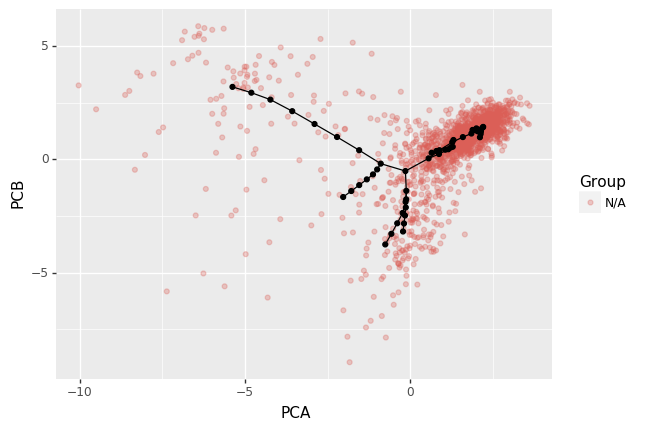

[<ggplot: (8731225223709)>]
Removed 1 vertices and 1 edges
15 labels generated


In [5]:
# Construct and post-process the principal tree

nnodes = 50

tree_elpi = elpigraph.computeElasticPrincipalTree(X,nnodes,drawPCAView=True,alpha=0.01,Mu=0.1,Lambda=0.05,FinalEnergy='Penalized')
tree_elpi = tree_elpi[0]
# some additional pruning of the graph
prune_the_tree(tree_elpi)
# extend the leafs to reach the extreme data points
tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)
# paritioning the data by tree branches
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended)
print(len(set(vec_labels_by_branches)),'labels generated')
# paritioning the data by proximity to nodes
nodep = tree_elpi['NodePositions']
partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, MaxBlockSize = 100000000, TrimmingRadius = np.inf,SquaredX = np.sum(X**2,axis=1,keepdims=1))
partition_by_node = np.zeros(len(partition))
for i,p in enumerate(partition):
    partition_by_node[i] = p[0]

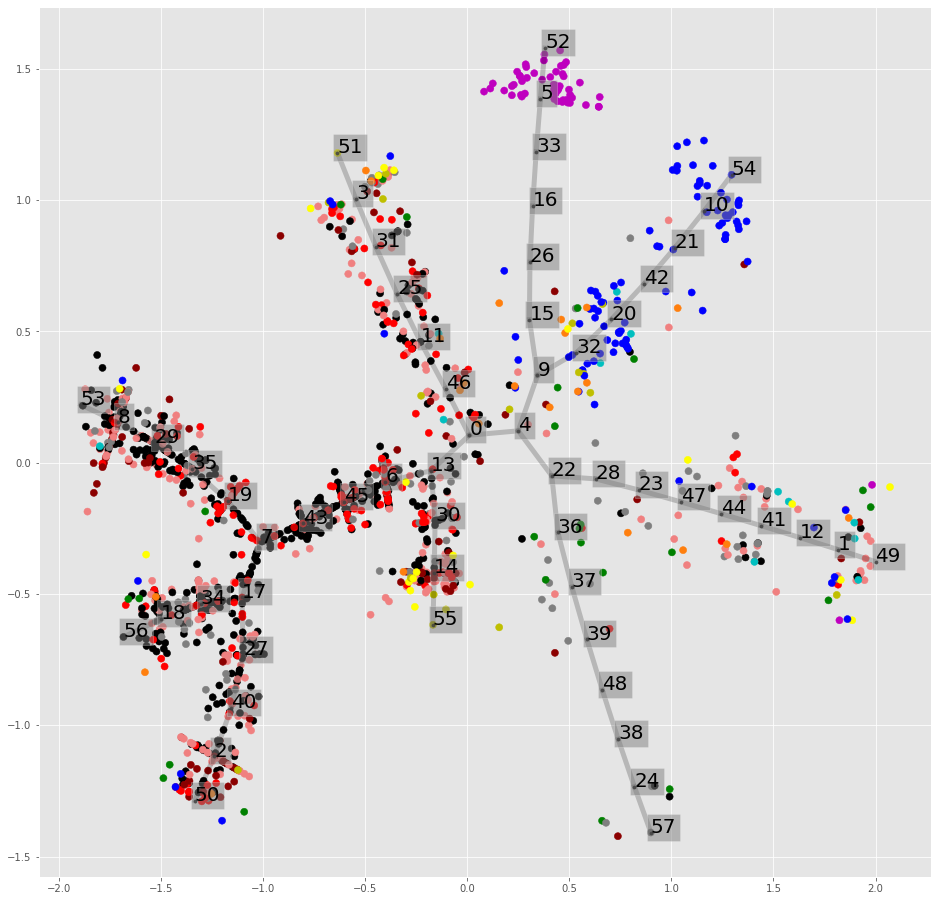

In [6]:
showEdgeNumbers=False
showNodeNumbers=True
showBranchNumbers=False
showPointNumbers=False
Color_by_feature = ''
Feature_Edge_Width = ''
Invert_Edge_Value = False
Min_Edge_Width = 5
Max_Edge_Width = 5
Big_Point_Size = 1000
Small_Point_Size = 100
Normal_Point_Size = 50
Visualize_Edge_Width_AsNodeCoordinates=True
Color_by_partitioning = False
Transparency_Alpha = 0.2
Visualize_Branch_Class_Associations = [] #list_of_branch_class_associations
cmap = 'hot'
highlight_subset = []
Color_by_partitioning=False
partitioning = vec_labels_by_branches
scatter_parameter = 0.03

#feature = 'LET_IS_0'
feature = ''
fig = plt.figure(figsize=(16, 16))
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,Color_by_feature=feature, Feature_Edge_Width=feature,Invert_Edge_Value=Invert_Edge_Value,Min_Edge_Width=Min_Edge_Width,Max_Edge_Width=Max_Edge_Width,Visualize_Edge_Width_AsNodeCoordinates=Visualize_Edge_Width_AsNodeCoordinates, Color_by_partitioning=Color_by_partitioning, visualize_partition=partitioning, showBranchNumbers=showBranchNumbers,showNodeNumbers=showNodeNumbers,scatter_parameter=scatter_parameter,cmap=cmap,Normal_Point_Size=Normal_Point_Size,highlight_subset=highlight_subset,Big_Point_Size=Big_Point_Size,showPointNumbers=showPointNumbers,Visualize_Branch_Class_Associations=Visualize_Branch_Class_Associations)

In [7]:
# Associate nodes (vec_labels_by_branches) and classes (color)
# The aim is to identify the root_node (the node most enriched with 'k' class - which means no complications)

Negative_Enrichment = False
Threshold_Deviation = 0.2
Minimal_number_of_points = 20
partitioning = partition_by_node

list_of_node_class_associations,p,stat = associate_with_categorical_var(partitioning,'CLASS',color,'CATEGORICAL',
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points)
    
print(list_of_node_class_associations)

k_nodes_scores = [(asst[0],asst[2]) for asst in list_of_node_class_associations if asst[1]=='k']
max_score_node = int(k_nodes_scores[np.argmax([t[1] for t in k_nodes_scores])][0])

root_node = max_score_node

print('Suggested root_node=',root_node)

[(2.0, 'lightcoral', 0.23732410973980034), (5.0, 'm', 0.9348494161032574), (6.0, 'r', 0.27759740259740256), (7.0, 'k', 0.25625942238907445), (8.0, 'lightcoral', 0.24030230309108494), (10.0, 'b', 0.8784737613802982), (14.0, 'lightcoral', 0.32046979865771813), (20.0, 'b', 0.8612534489554592), (29.0, 'k', 0.22539687033327901), (34.0, 'k', 0.23267844906134932), (35.0, 'k', 0.22852204939510506), (43.0, 'k', 0.32395616720016823), (45.0, 'k', 0.21064669567857502), (45.0, 'r', 0.3724315717643491)]
Suggested root_node= 43


SEX BINARY [(13.0, -0.35600000000000004, 0.34051160385679957)] p-value= 2.6721970460596024e-45
nr_11 BINARY [(6.0, 1.944, 0.8789542795750269)] p-value= 1.1795093161608191e-29
nr_03 BINARY [(5.0, 2.042, 0.7391526071990141)] p-value= 1.5347353657498922e-11
nr_04 BINARY [(5.0, 2.1, 0.8816497310221159)] p-value= 1.3949841801582434e-78
endocr_01 BINARY [(13.0, 1.089, 0.46769681630478216)] p-value= 2.6812102862356785e-23
zab_leg_02 BINARY [(3.0, 1.463, 0.3377853326857698), (5.0, 1.463, 0.3466145196773405)] p-value= 2.7126194791943737e-11
O_L_POST BINARY [(3.0, 1.5, 0.5483813271328921), (13.0, 1.5, 0.5103067200476458)] p-value= 1.754674781055884e-22
K_SH_POST BINARY [(3.0, 1.965, 0.8729494959797371)] p-value= 3.418052429724638e-96
MP_TP_POST BINARY [(5.0, 1.475, 0.8576428455152205)] p-value= 1.683718449881947e-229


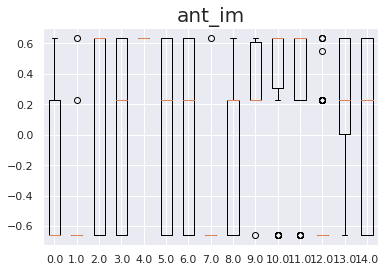

ant_im ORDINAL [(9.0, 'CONTINUOUS', 0.5356103896103925), (10.0, 'CONTINUOUS', 0.7183548872180492), (11.0, 'CONTINUOUS', 0.6579649952696344)] p-value= 4.0225871465801615e-155


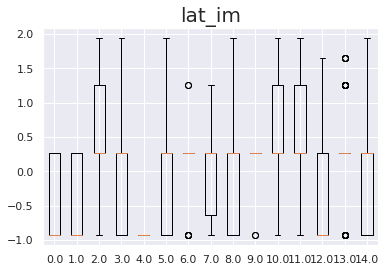

lat_im ORDINAL [(2.0, 'CONTINUOUS', 0.80597044334976), (10.0, 'CONTINUOUS', 1.0395007518797057), (11.0, 'CONTINUOUS', 0.9561229895931932)] p-value= 1.3171152262356079e-84
IM_PG_P BINARY [(3.0, 1.8630000000000002, 0.5983075946689231)] p-value= 4.2096291383220633e-08
ritm_ecg_p_01 BINARY [(3.0, -0.358, 0.34848561205462886), (5.0, -0.358, 0.48144207554118756), (13.0, -0.358, 0.4438989307442226)] p-value= 1.1114529664324576e-110
ritm_ecg_p_02 BINARY [(5.0, 1.521, 0.8686406648276825)] p-value= 5.385789770867972e-246
ritm_ecg_p_07 BINARY [(3.0, 0.802, 0.3897492274265731), (13.0, 0.802, 0.5760669730794484)] p-value= 1.688765918480542e-92
ritm_ecg_p_08 BINARY [(12.0, 1.871, 0.4172883972215076)] p-value= 0.010990642799458024
n_r_ecg_p_04 BINARY [(10.0, 1.6840000000000002, 0.4682835820895523)] p-value= 2.572011546193854e-10
n_r_ecg_p_05 BINARY [(5.0, 1.6840000000000002, 0.856151618847065)] p-value= 9.361654835355462e-139
n_r_ecg_p_06 BINARY [(5.0, 2.029, 0.8742557751845677)] p-value= 4.683644636

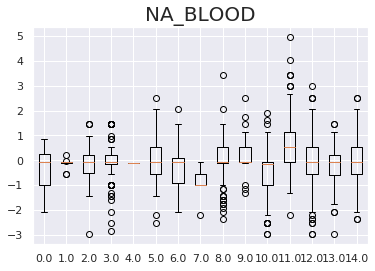

NA_BLOOD CONTINUOUS [(11.0, 'CONTINUOUS', 1.0879555345316894)] p-value= 3.048691574774228e-28


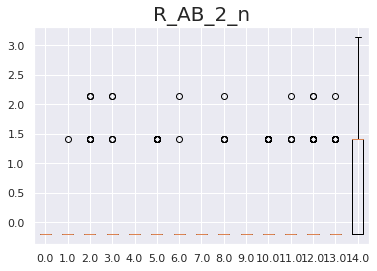

R_AB_2_n ORDINAL [(14.0, 'CONTINUOUS', 1.024011976047923)] p-value= 5.299906929325294e-96


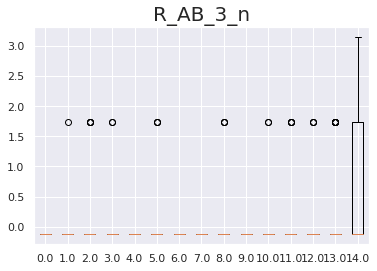

R_AB_3_n ORDINAL [(14.0, 'CONTINUOUS', 0.7944790419161492)] p-value= 6.132323546219366e-84


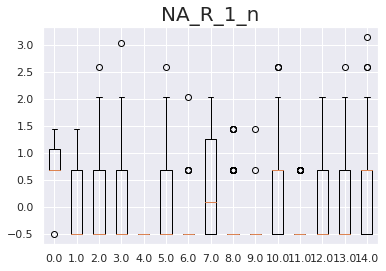

NA_R_1_n ORDINAL [(0.0, 'CONTINUOUS', 0.7305714285714243)] p-value= 5.1547837684726477e-39


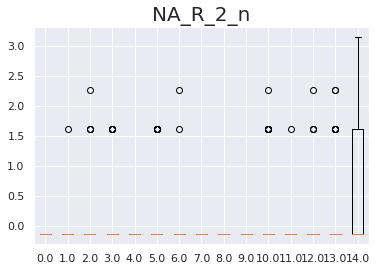

NA_R_2_n ORDINAL [(14.0, 'CONTINUOUS', 0.8561976047904359)] p-value= 6.695642591556288e-87


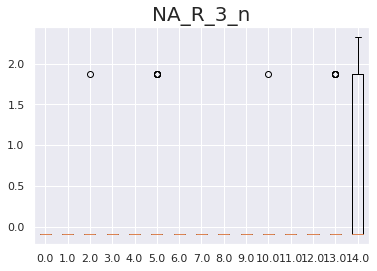

NA_R_3_n ORDINAL [(14.0, 'CONTINUOUS', 0.696946107784439)] p-value= 1.5709276253741806e-88


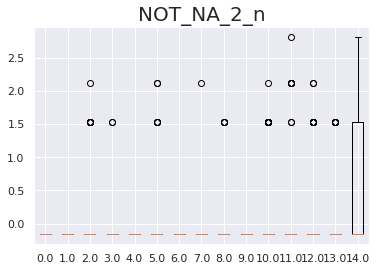

NOT_NA_2_n ORDINAL [(14.0, 'CONTINUOUS', 0.7938323353293588)] p-value= 1.6484691145748678e-60


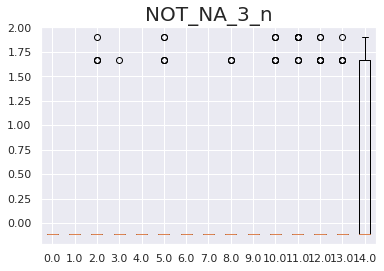

NOT_NA_3_n ORDINAL [(14.0, 'CONTINUOUS', 0.5782455089820315)] p-value= 1.4056759005054127e-42
LID_S_n BINARY [(10.0, 0.655, 0.38074114223769046)] p-value= 1.6226709247852748e-33
B_BLOK_S_n BINARY [(11.0, 1.129, 0.314790775378433)] p-value= 1.3700435095602148e-09
ANT_CA_S_n BINARY [(3.0, -0.358, 0.36370668795524447)] p-value= 3.695779329487597e-16
ASP_S_n BINARY [(3.0, -0.35700000000000004, 0.41561614677798925)] p-value= 4.3817502658381196e-14
FIBR_PREDS BINARY [(5.0, 1.274, 0.5329691233089344)] p-value= 5.149783300329627e-14
FIBR_JELUD BINARY [(10.0, 1.7069999999999999, 0.4682835820895522)] p-value= 1.3019976467728281e-14
A_V_BLOK BINARY [(12.0, 1.817, 0.3343506273312987)] p-value= 2.1220564172427112e-07
OTEK_LANC BINARY [(3.0, 1.318, 0.34866626079505736), (5.0, 1.318, 0.35742005764473594), (13.0, 1.318, 0.4210051158591634)] p-value= 2.3183745785190168e-18
RAZRIV BINARY [(2.0, 1.8090000000000002, 0.9262369822911168)] p-value= 2.7399093517177585e-274
DRESSLER BINARY [(10.0, 1.665, 0.348

In [95]:
# Associate branches (vec_labels_by_branches) and variables (chi-square : binary, ordinal and categorical
# and ANOVA for continuous)

Negative_Enrichment = False
Threshold_Deviation = 0.3
Threshold_Parameter = 0.3
Minimal_number_of_points = 10
pvalue_threshold_parameter = 0.01
produce_plots = True

all_branch_var_associations = {}

for k,var in enumerate(variable_names):
    var_type = variable_types[k]
    vals = X_original[:,k]
    list_of_branch_var_associations=[]
    if var_type=='BINARY' or var_type=='CATEGORICAL':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if var_type=='ORDINAL' or var_type=='CONTINUOUS':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Parameter,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if len(list_of_branch_var_associations)>0:
        print(var,var_type,list_of_branch_var_associations,'p-value=',p)
        all_branch_var_associations[var] = list_of_branch_var_associations

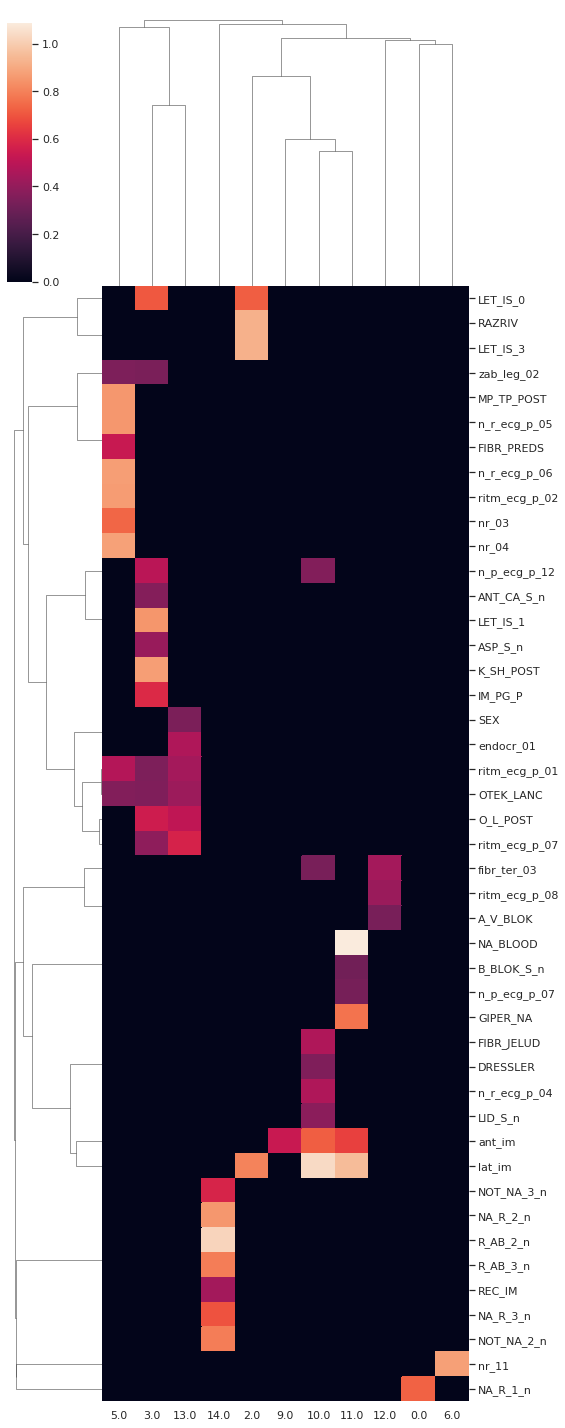

In [96]:
# Visualize associations between variables and tree branches

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_branch_var_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
print()

In [9]:
# Quantify pseudo-time

all_trajectories = extract_trajectories(tree_extended,root_node)
print(len(all_trajectories),' trajectories found.')
ProjStruct = project_on_tree(X,tree_extended)
PseudoTimeTraj = quantify_pseudotime(all_trajectories,ProjStruct)

9  trajectories found.


/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zinovyev/anaconda3/lib/python3.

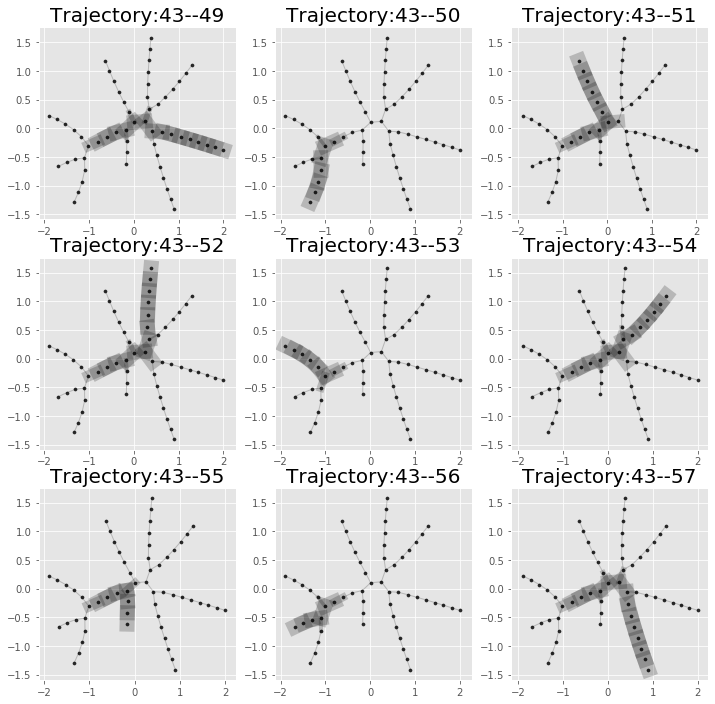

In [10]:
# Visualize all trajectories
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

n_subplots_x, n_subplots_y = 3, 3
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 12))

for i,pstt in enumerate(PseudoTimeTraj):
    points = list(pstt['Points'])
    X_fake = np.zeros((X.shape[0],1))
    X_fake[points,0] = 1.0
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i+1)
    plt.title(TrajName,fontsize=20)
    visualize_eltree_with_data(tree_extended,X,X_fake,v,mean_val,color,['Traj'],
                          Min_Edge_Width=1,Max_Edge_Width=15,Normal_Point_Size = 0,
                          Color_by_feature='', Feature_Edge_Width='Traj',
                          Visualize_Edge_Width_AsNodeCoordinates=False)



AGE CONTINUOUS
SEX BINARY
INF_ANAM ORDINAL
STENOK_AN ORDINAL


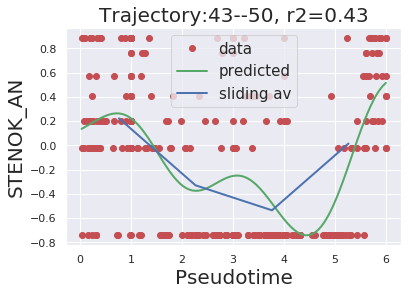

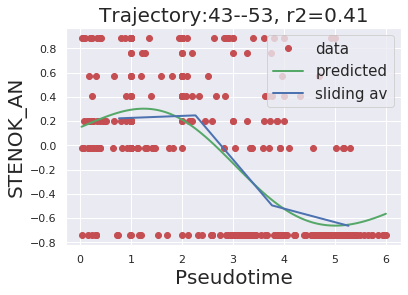

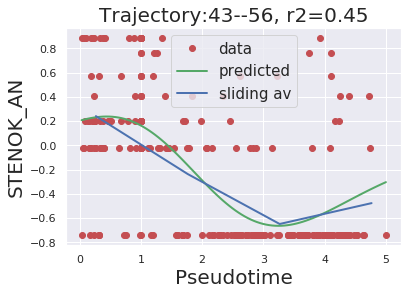

[('Trajectory:43--50', 'STENOK_AN', 0.4267106401159021), ('Trajectory:43--53', 'STENOK_AN', 0.4116443226197657), ('Trajectory:43--56', 'STENOK_AN', 0.4505232791299485)]
FK_STENOK ORDINAL


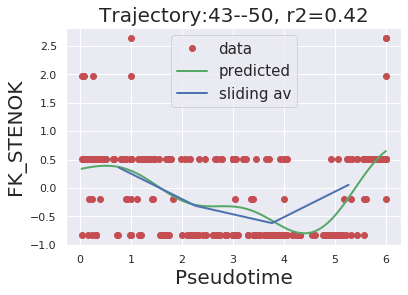

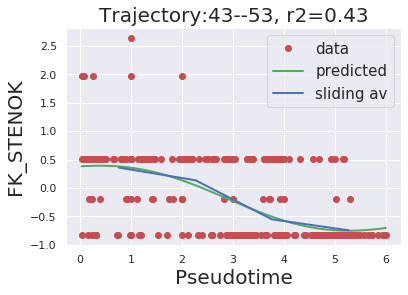

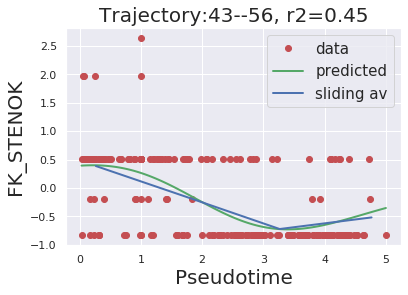

[('Trajectory:43--50', 'FK_STENOK', 0.4240002790713433), ('Trajectory:43--53', 'FK_STENOK', 0.43410040031535724), ('Trajectory:43--56', 'FK_STENOK', 0.44953443679259886)]
IBS_POST ORDINAL


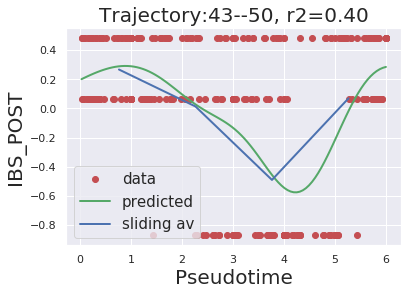

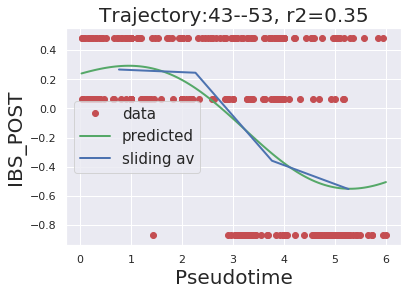

[('Trajectory:43--50', 'IBS_POST', 0.39830073073643923), ('Trajectory:43--53', 'IBS_POST', 0.3522935643311603)]
GB ORDINAL
SIM_GIPERT BINARY
DLIT_AG ORDINAL
ZSN_A ORDINAL
nr_11 BINARY
nr_01 BINARY
nr_02 BINARY
nr_03 BINARY
nr_04 BINARY


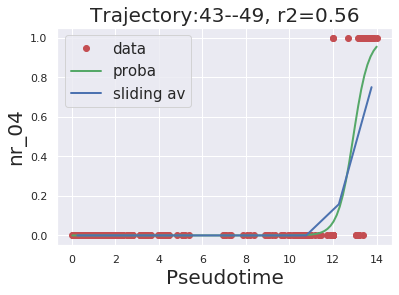

[('Trajectory:43--49', 'nr_04', 0.5630227001194744)]
nr_07 BINARY
nr_08 BINARY
np_01 BINARY
np_04 BINARY
np_05 BINARY
np_07 BINARY
np_08 BINARY
np_09 BINARY
np_10 BINARY


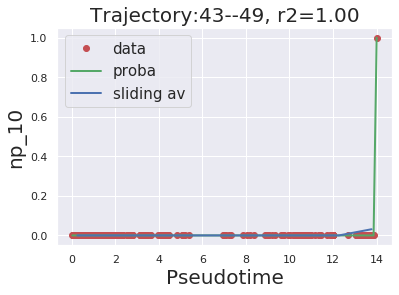

[('Trajectory:43--49', 'np_10', 1.0)]
endocr_01 BINARY
endocr_02 BINARY
endocr_03 BINARY
zab_leg_01 BINARY
zab_leg_02 BINARY
zab_leg_03 BINARY
zab_leg_04 BINARY
zab_leg_06 BINARY
S_AD_ORIT CONTINUOUS


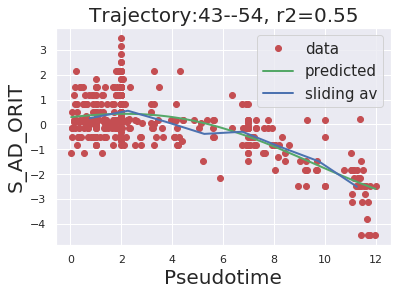

[('Trajectory:43--54', 'S_AD_ORIT', 0.5474405910099165)]
D_AD_ORIT CONTINUOUS


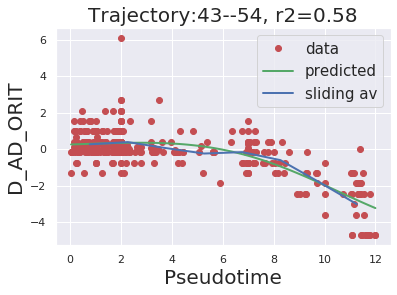

[('Trajectory:43--54', 'D_AD_ORIT', 0.5844439750078783)]
O_L_POST BINARY
K_SH_POST BINARY


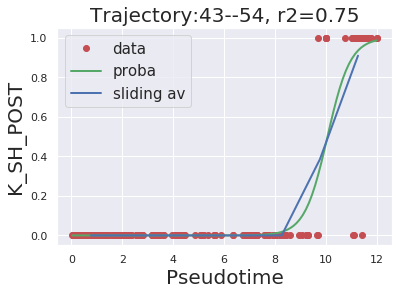

[('Trajectory:43--54', 'K_SH_POST', 0.7499808502489468)]
MP_TP_POST BINARY


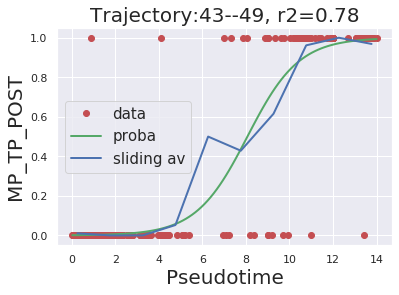

[('Trajectory:43--49', 'MP_TP_POST', 0.7830735773831098)]
SVT_POST BINARY


/mnt/c/Datas/Golovenkin/clintraj_util.py:92: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


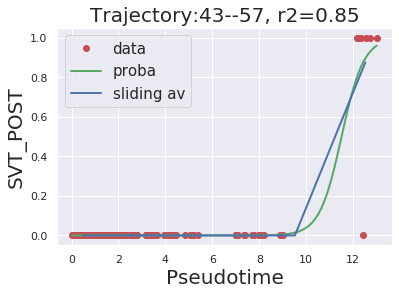

[('Trajectory:43--57', 'SVT_POST', 0.8540080609046126)]
GT_POST BINARY
FIB_G_POST BINARY


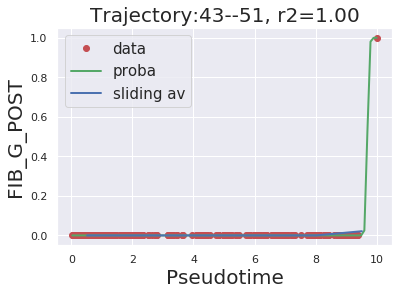

[('Trajectory:43--51', 'FIB_G_POST', 1.0)]
ant_im ORDINAL


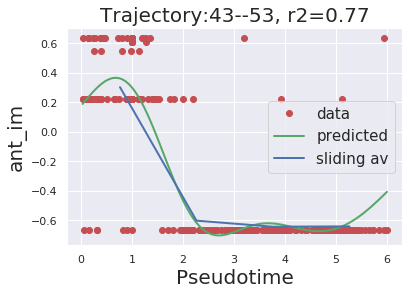

[('Trajectory:43--53', 'ant_im', 0.7728148465456073)]
lat_im ORDINAL
inf_im ORDINAL


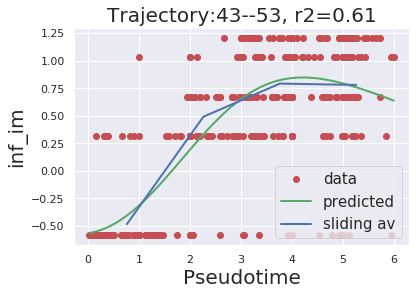

[('Trajectory:43--53', 'inf_im', 0.6103883436226534)]
post_im ORDINAL
IM_PG_P BINARY
ritm_ecg_p_01 BINARY


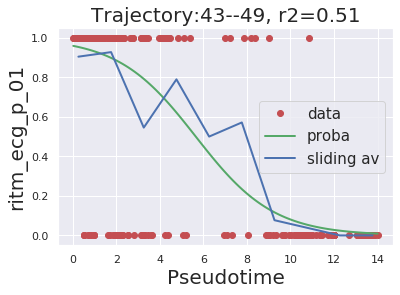

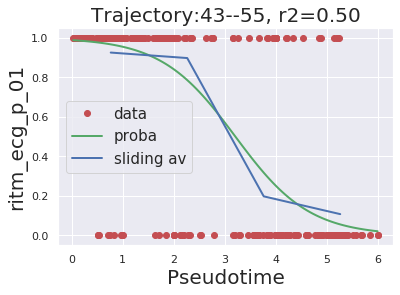

[('Trajectory:43--49', 'ritm_ecg_p_01', 0.5148795738767948), ('Trajectory:43--55', 'ritm_ecg_p_01', 0.5016680774784644)]
ritm_ecg_p_02 BINARY


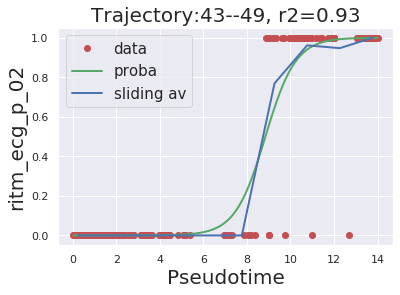

[('Trajectory:43--49', 'ritm_ecg_p_02', 0.9252529037092544)]
ritm_ecg_p_04 BINARY
ritm_ecg_p_06 BINARY
ritm_ecg_p_07 BINARY


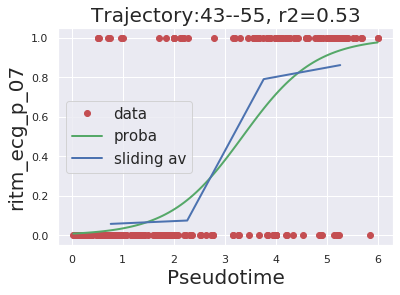

[('Trajectory:43--55', 'ritm_ecg_p_07', 0.5301408450704226)]
ritm_ecg_p_08 BINARY
n_r_ecg_p_01 BINARY
n_r_ecg_p_02 BINARY
n_r_ecg_p_03 BINARY
n_r_ecg_p_04 BINARY
n_r_ecg_p_05 BINARY


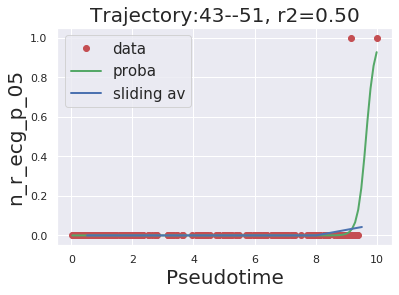

[('Trajectory:43--51', 'n_r_ecg_p_05', 0.4977924944812362)]
n_r_ecg_p_06 BINARY


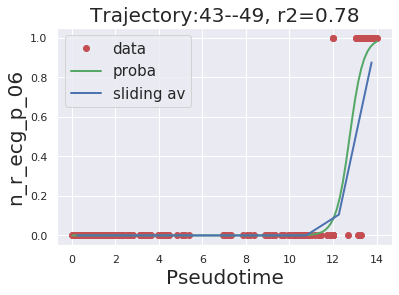

[('Trajectory:43--49', 'n_r_ecg_p_06', 0.783739837398374)]
n_r_ecg_p_08 BINARY


/mnt/c/Datas/Golovenkin/clintraj_util.py:92: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


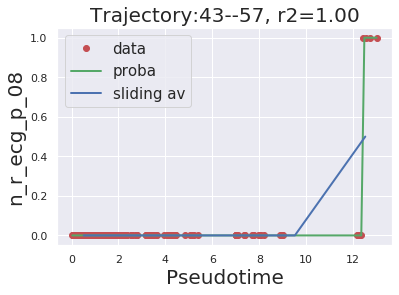

[('Trajectory:43--57', 'n_r_ecg_p_08', 1.0)]
n_r_ecg_p_09 BINARY
n_r_ecg_p_10 BINARY
n_p_ecg_p_01 BINARY
n_p_ecg_p_03 BINARY
n_p_ecg_p_04 BINARY
n_p_ecg_p_05 BINARY
n_p_ecg_p_06 BINARY
n_p_ecg_p_07 BINARY
n_p_ecg_p_08 BINARY
n_p_ecg_p_09 BINARY
n_p_ecg_p_10 BINARY
n_p_ecg_p_11 BINARY
n_p_ecg_p_12 BINARY
fibr_ter_01 BINARY
fibr_ter_02 BINARY
fibr_ter_03 BINARY
fibr_ter_05 BINARY
fibr_ter_06 BINARY
fibr_ter_07 BINARY
fibr_ter_08 BINARY
GIPO_K BINARY
K_BLOOD CONTINUOUS
GIPER_NA BINARY


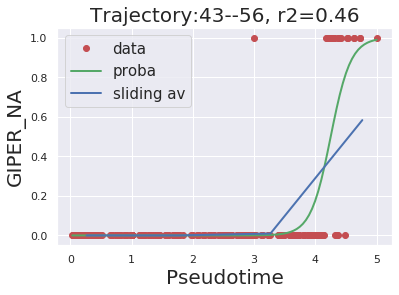

[('Trajectory:43--56', 'GIPER_NA', 0.4570312500000001)]
NA_BLOOD CONTINUOUS


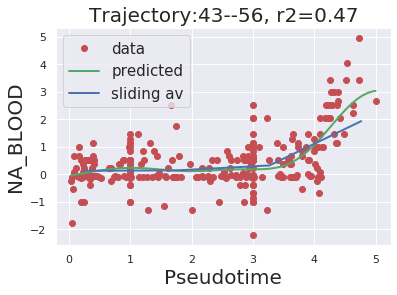

[('Trajectory:43--56', 'NA_BLOOD', 0.4707113899099832)]
ALT_BLOOD CONTINUOUS
AST_BLOOD CONTINUOUS
L_BLOOD CONTINUOUS
ROE CONTINUOUS
TIME_B_S ORDINAL
R_AB_1_n ORDINAL
R_AB_2_n ORDINAL


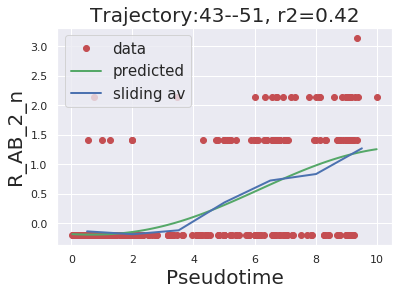

[('Trajectory:43--51', 'R_AB_2_n', 0.42013152667853493)]
R_AB_3_n ORDINAL


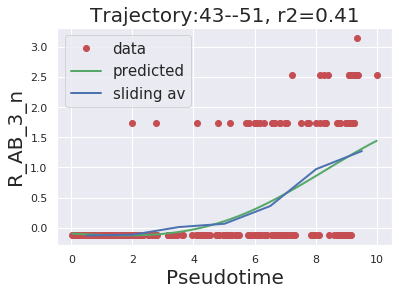

[('Trajectory:43--51', 'R_AB_3_n', 0.40821097830425257)]
NITR_S ORDINAL
NA_R_1_n ORDINAL


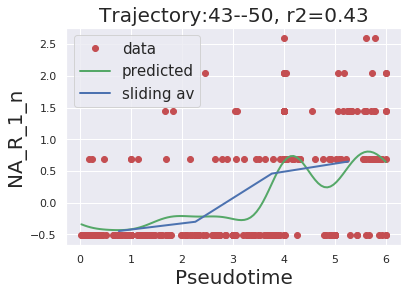

[('Trajectory:43--50', 'NA_R_1_n', 0.43039224216517635)]
NA_R_2_n ORDINAL


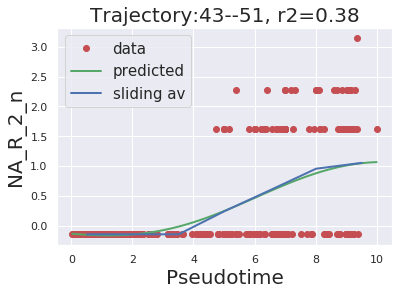

[('Trajectory:43--51', 'NA_R_2_n', 0.3799988742597509)]
NA_R_3_n ORDINAL


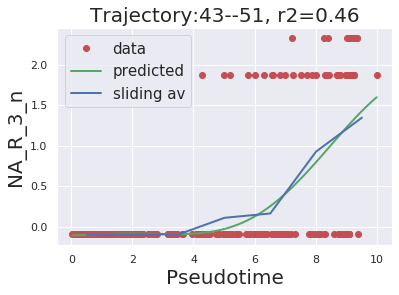

[('Trajectory:43--51', 'NA_R_3_n', 0.4624493815496328)]
NOT_NA_1_n ORDINAL
NOT_NA_2_n ORDINAL
NOT_NA_3_n ORDINAL
LID_S_n BINARY
B_BLOK_S_n BINARY
ANT_CA_S_n BINARY
GEPAR_S_n BINARY
ASP_S_n BINARY
TIKL_S_n BINARY
TRENT_S_n BINARY
FIBR_PREDS BINARY
PREDS_TAH BINARY
JELUD_TAH BINARY
FIBR_JELUD BINARY
A_V_BLOK BINARY
OTEK_LANC BINARY
RAZRIV BINARY


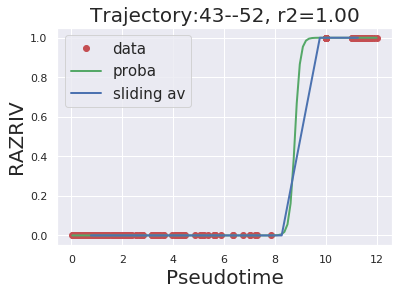

[('Trajectory:43--52', 'RAZRIV', 1.0)]
DRESSLER BINARY
ZSN BINARY
REC_IM BINARY
P_IM_STEN BINARY
LET_IS_0 BINARY


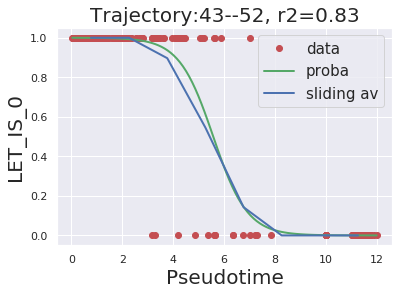

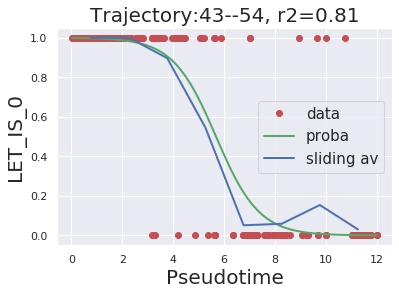

[('Trajectory:43--52', 'LET_IS_0', 0.8335360291882031), ('Trajectory:43--54', 'LET_IS_0', 0.8064271255060729)]
LET_IS_1 BINARY


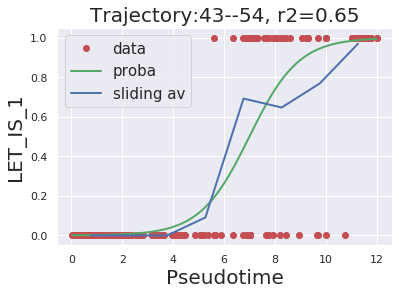

[('Trajectory:43--54', 'LET_IS_1', 0.6457129912787405)]
LET_IS_2 BINARY
LET_IS_3 BINARY


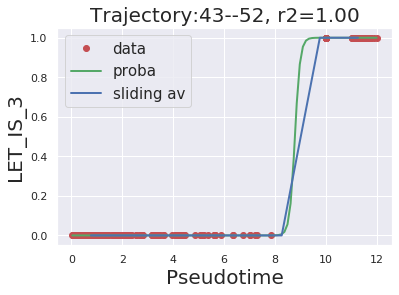

[('Trajectory:43--52', 'LET_IS_3', 1.0)]
LET_IS_4 BINARY
LET_IS_5 BINARY
LET_IS_6 BINARY
LET_IS_7 BINARY


In [181]:
# associate trajectories with variables by regression

R2_Threshold = 0.3
producePlot = True
all_trajectory_variable_associations = {}
for k,var in enumerate(variable_names):
    print(var,variable_types[variable_names.index(var)])
    List_of_Associations = regression_of_variable_with_trajectories(PseudoTimeTraj,var,variable_names,variable_types,X_original,R2_Threshold=R2_Threshold,producePlot=True,Continuous_Regression_Type='gpr')
    if len(List_of_Associations)>0:
        print(List_of_Associations)
        all_trajectory_variable_associations[var]=List_of_Associations


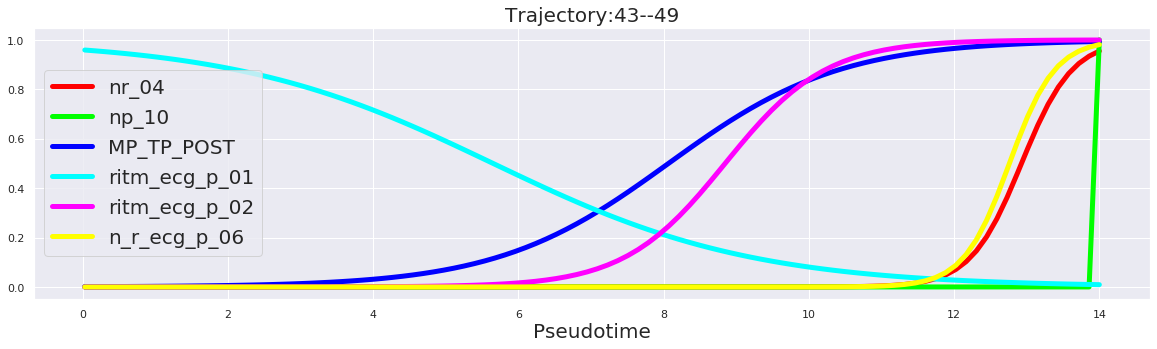

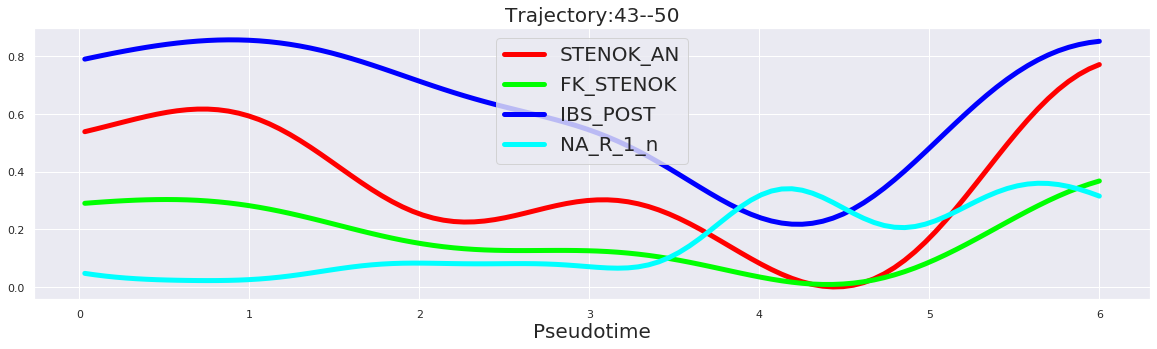

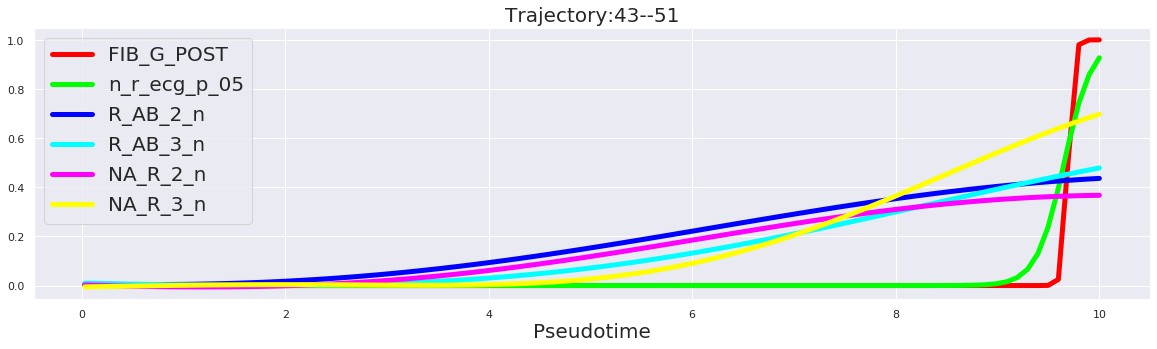

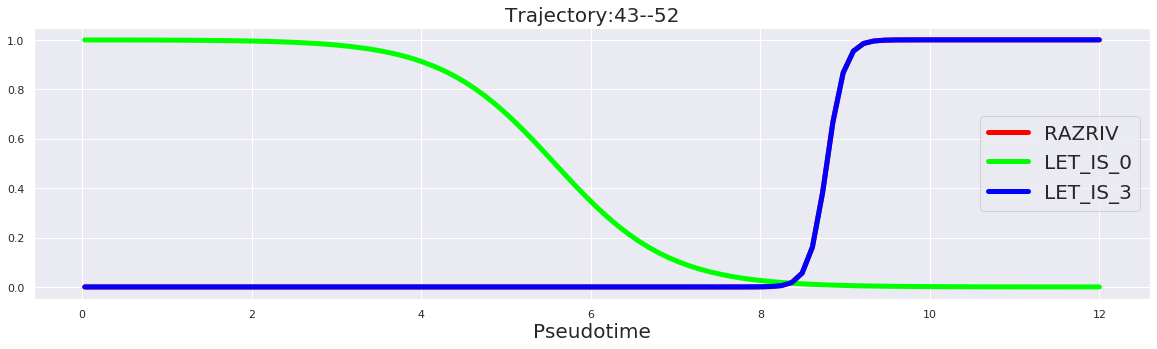

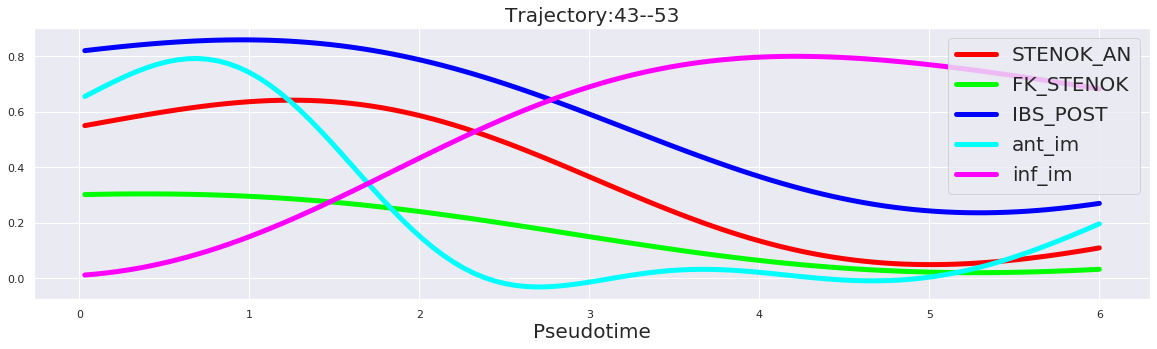

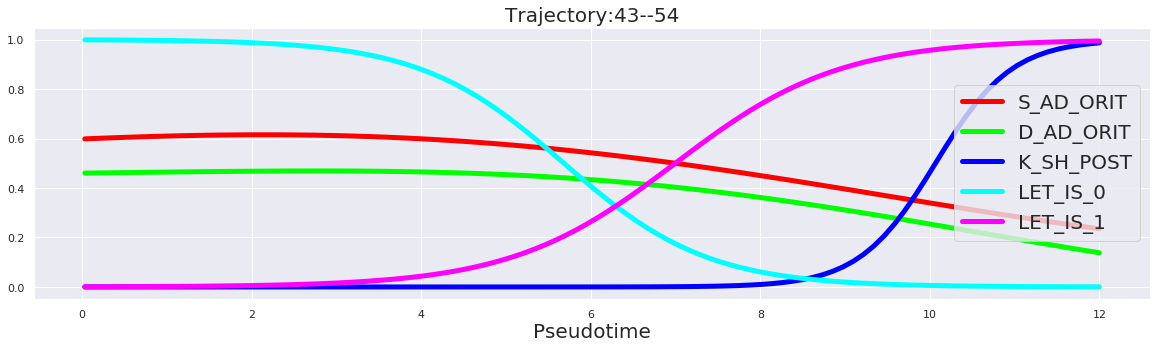

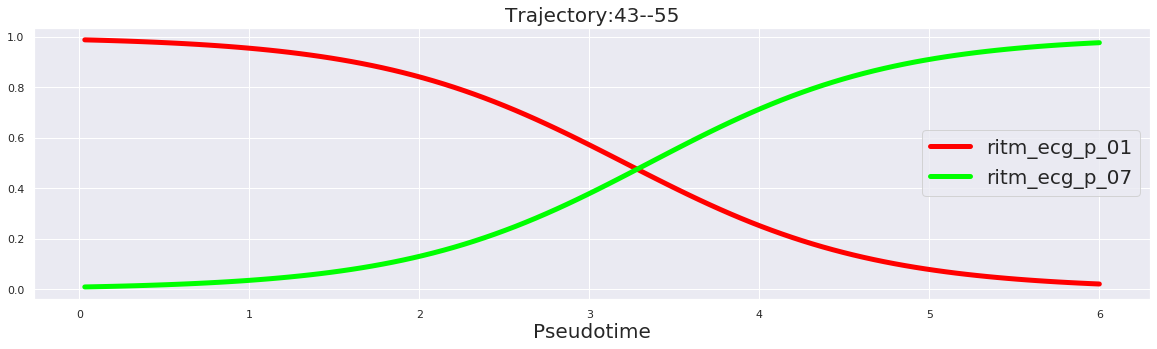

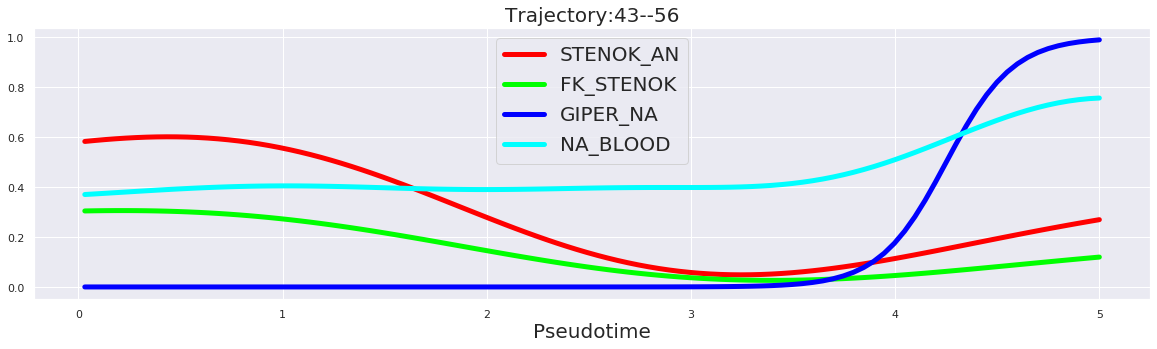

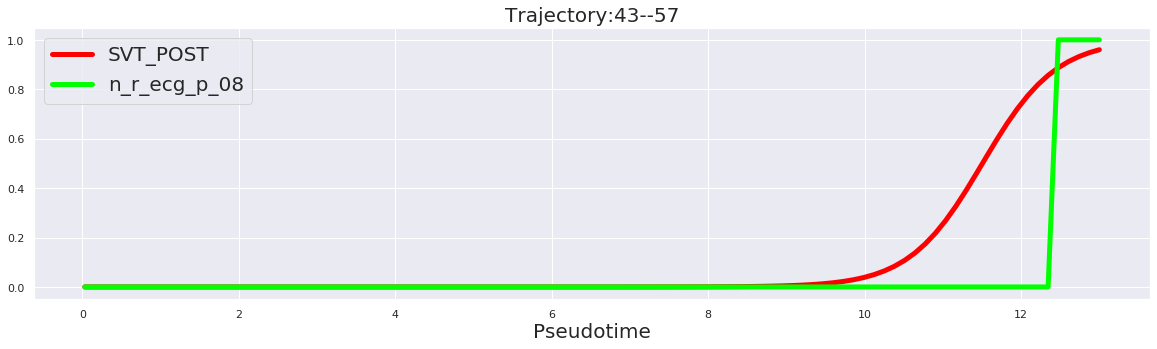

In [194]:
# Draw pseudotime dependencies of variables significantly associated with trajectories

for pstt in PseudoTimeTraj:
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    color_seq = get_standard_color_seq()
    fig = plt.figure(figsize=(20, 5))
    k=0
    for var in all_trajectory_variable_associations:
        associations = all_trajectory_variable_associations[var]
        for assoc in associations:
            trajn = assoc[0]
            if trajn==TrajName:
                var = assoc[1]
                draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,color_seq[k],
                                           linewidth=5,draw_datapoints=False)
                k=k+1    
    #plt.ylim(-0.1,1.1)
    plt.legend(fontsize=20)
    plt.title(TrajName,fontsize=20)
    plt.show()

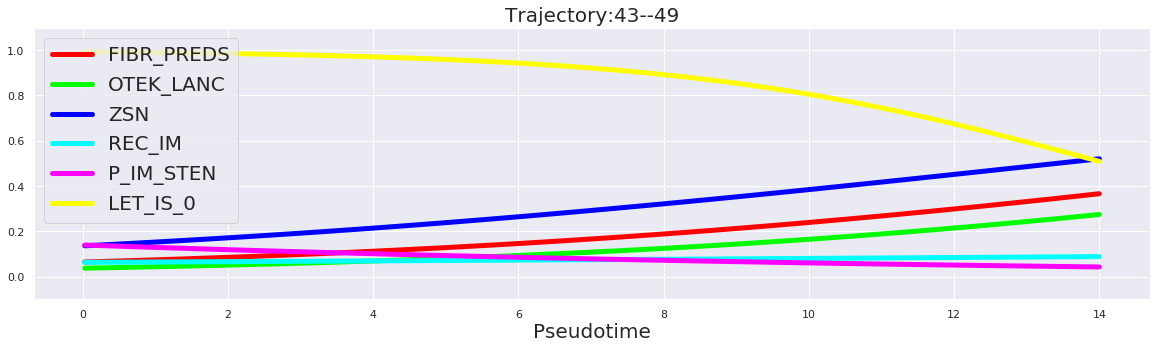

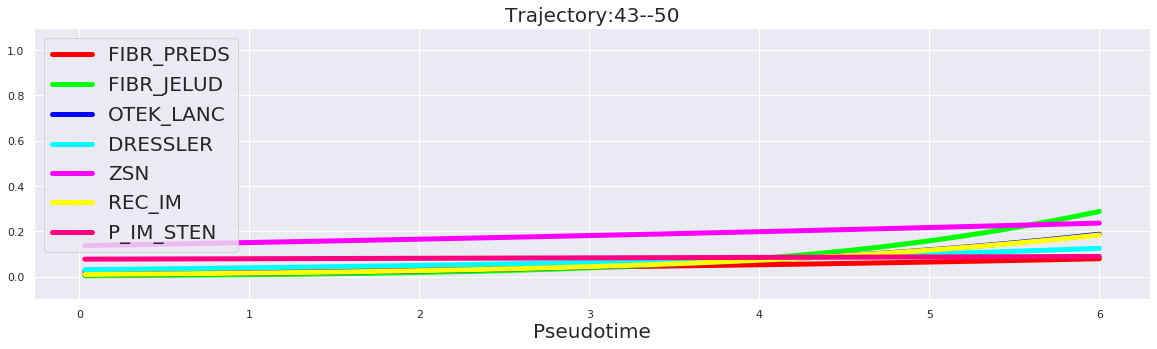

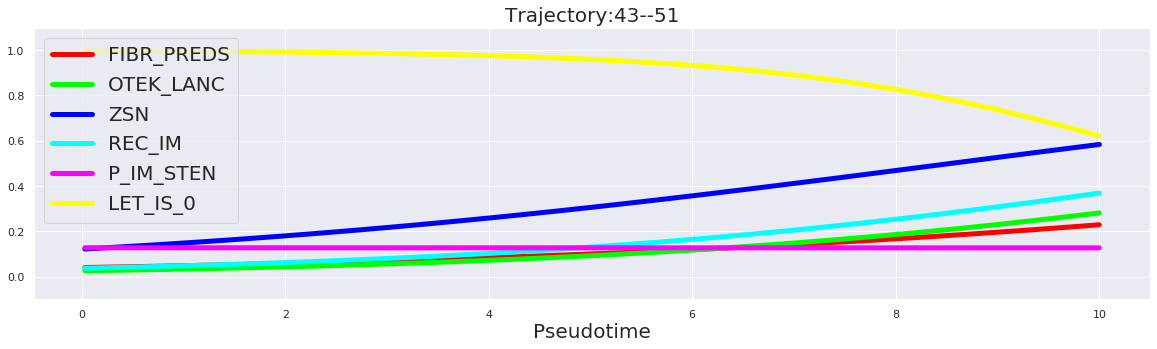

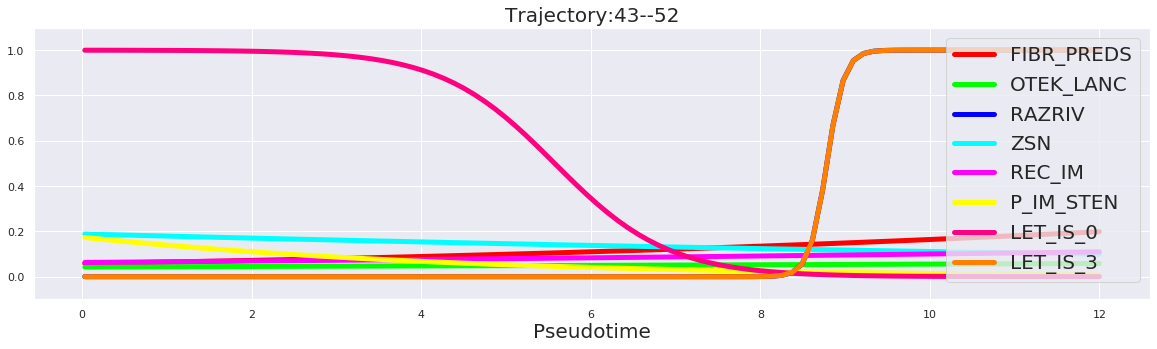

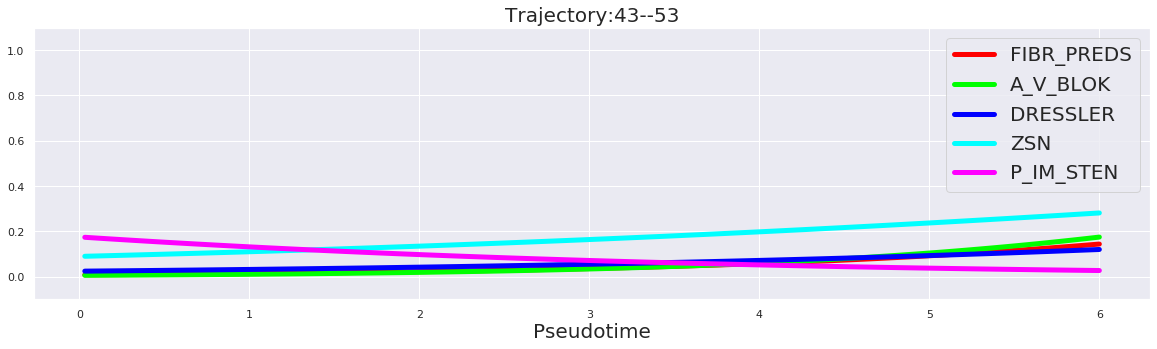

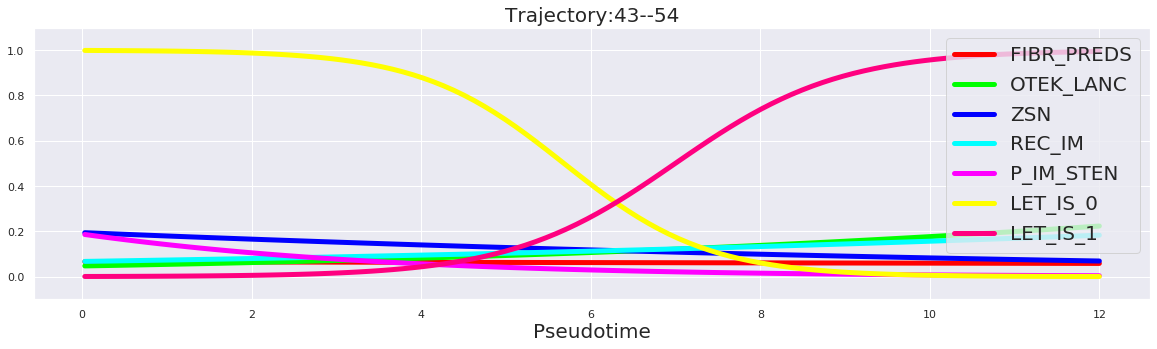

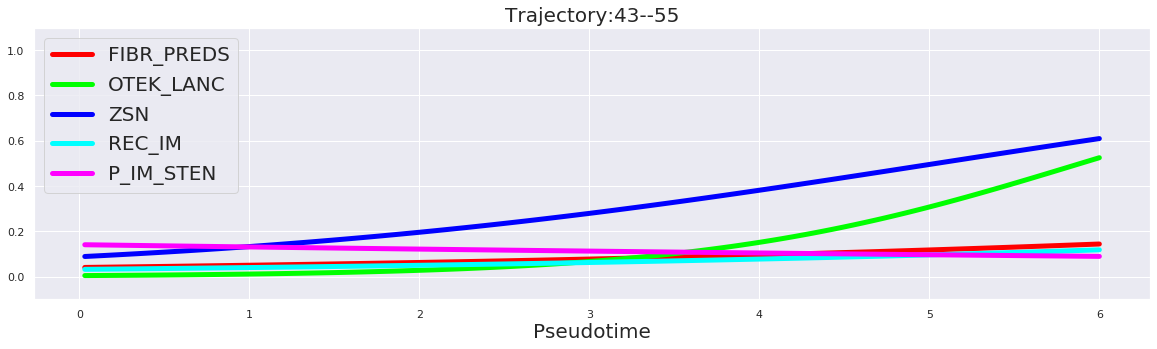

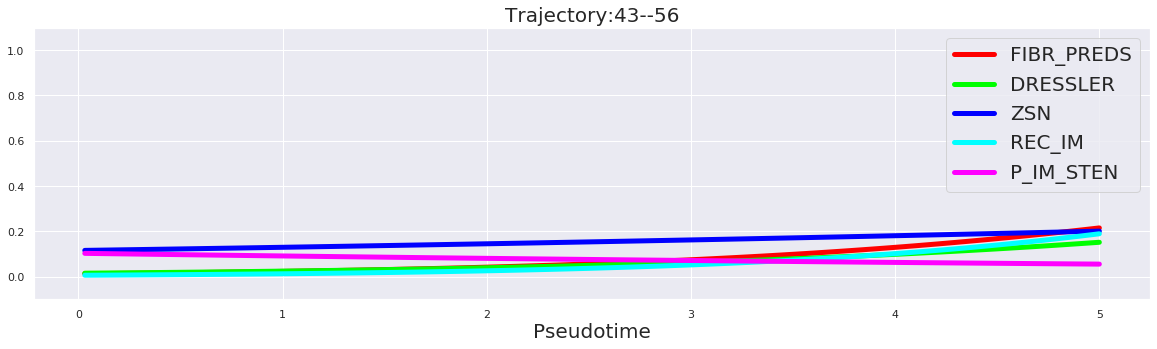

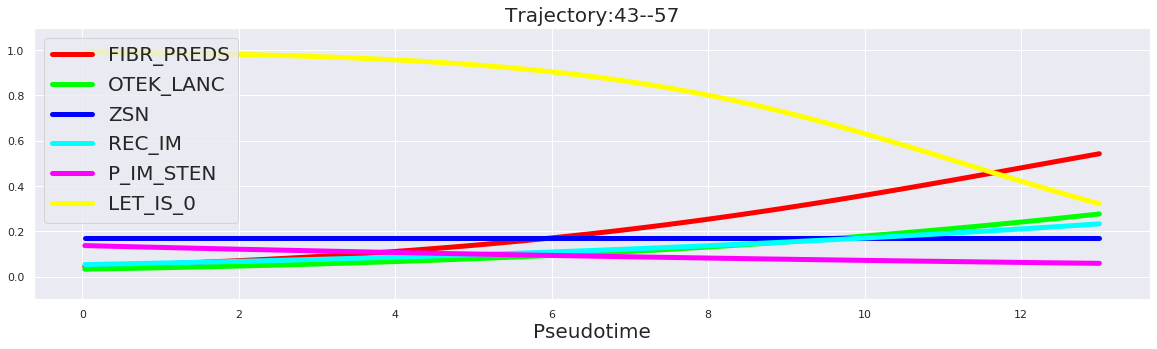

In [218]:
# Visualize all complications variables for all trajectories

complication_variables = ['FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD','A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER','ZSN','REC_IM','P_IM_STEN','LET_IS_0','LET_IS_1','LET_IS_2','LET_IS_3','LET_IS_4','LET_IS_5','LET_IS_6','LET_IS_7']

for pstt in PseudoTimeTraj:
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    color_seq = get_standard_color_seq()
    fig = plt.figure(figsize=(20, 5))
    color_k=0
    for var in complication_variables:
        k = variable_names.index(var)
        vals_traj = X_original[pstt['Points'],k]
        vals_glob = X_original[:,k]
        mn = min(vals_glob)
        mx = max(vals_glob)
        vals_traj = (vals_traj-mn)/(mx-mn)
        vals_glob = (vals_glob-mn)/(mx-mn)
        variance = np.std(vals_traj)
        variance_glob = np.std(vals_glob)
        norm_variance = variance
        #print(var,TrajName,variance,norm_variance,mn,mx)
        if norm_variance>0.2:
            draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,color_seq[color_k],
                                           linewidth=5,draw_datapoints=False)
            color_k=color_k+1    
    plt.ylim(-0.1,1.1)
    plt.legend(fontsize=20)
    plt.title(TrajName,fontsize=20)
    plt.show()

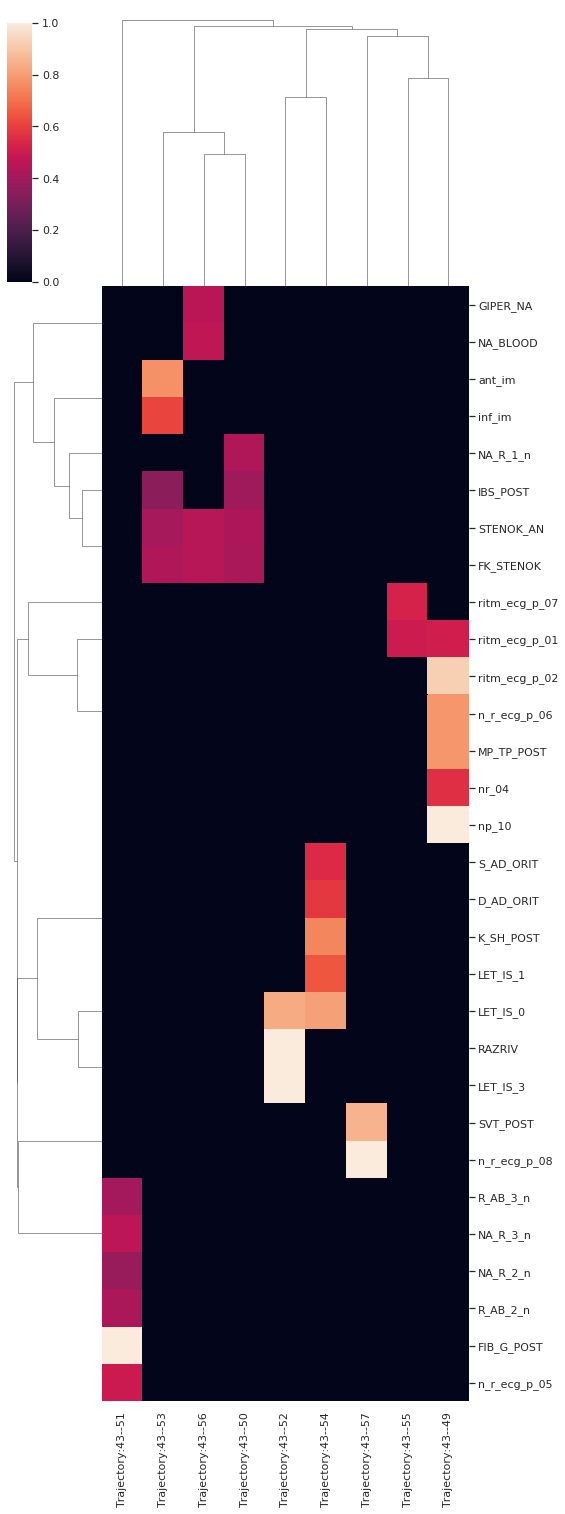

In [183]:
# Visualize associations between variables and trajectories

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_trajectory_variable_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
print()


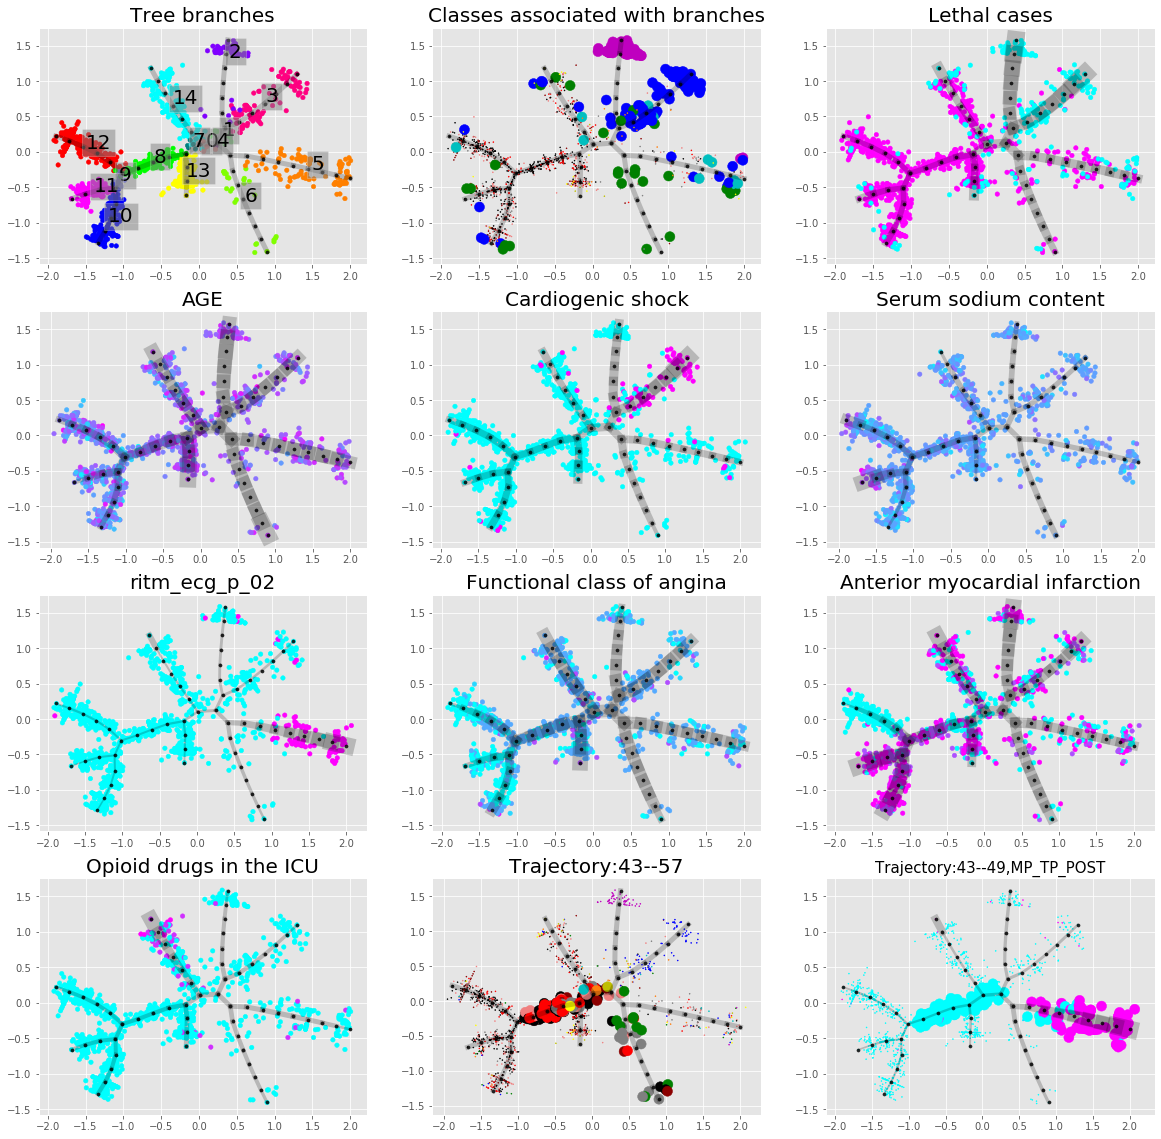

In [32]:
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

# visualizing some of the results on top of the tree

n_subplots_x, n_subplots_y = 4, 3
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))

# Visualize partionining of data by branches
i=1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          showBranchNumbers=True,Color_by_partitioning=True,visualize_partition=vec_labels_by_branches)
plt.title('Tree branches',fontsize=20)

# Show only points of classes strongly associated with branches
i=i+1
list_of_node_class_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,'CLASS',color,'CATEGORICAL',
                                                            score_threshold=0.7,
                                                            Negative_Enrichment=False,
                                                            Minimal_number_of_points=5,verbose=False)
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Classes associated with branches',fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Visualize_Branch_Class_Associations=list_of_node_class_associations)


# Visualize survival risk
i=i+1
feature='LET_IS_0'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Lethal cases',fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize patient age
i=i+1
feature='AGE'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('AGE',fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)


# Visualize cases of cardiogenic shock
i=i+1
feature='LET_IS_1'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Cardiogenic shock',fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize Serum sodium content NA_BLOOD
i=i+1
feature='NA_BLOOD'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Serum sodium content',fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# ritm_ecg_p_02 - example of a strong association with binary variable
i=i+1
feature='ritm_ecg_p_02'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title(feature,fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize Functional class of angina FK_STENOK
i=i+1
feature='FK_STENOK'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Functional class of angina',fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)


# Visualize anterior myocardial infarction ant_im
i=i+1
feature='ant_im'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Anterior myocardial infarction',fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize use of Opioid drugs in the ICU NA_R_3_n
i=i+1
feature='NA_R_3_n'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Opioid drugs in the ICU',fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)


# visualize a particular trajectory
pstt = PseudoTimeTraj[8]
points = list(pstt['Points'])
TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
i=i+1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title(TrajName,fontsize=20)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          highlight_subset=points,Big_Point_Size = 100,Normal_Point_Size = 1)

# visualize a particular trajectory with an associated variable 
pstt = PseudoTimeTraj[0]
points = list(pstt['Points'])
TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
i=i+1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
feature = 'MP_TP_POST'
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          highlight_subset=points,Big_Point_Size = 100,Normal_Point_Size = 1,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)
plt.title(TrajName+','+feature,fontsize=15)


plt.show()

Start computations...
PCA: 0.0054 sec
Computing LLE...
LLE: 0.7 sec
Modified LLE: 0.93 sec
Isomap: 1.5 sec
MDS: 3.7 sec
SpectralEmbedding: 0.6 sec
t-SNE: 6.8 sec
UMAP: 3.1 sec
TRIMAP: 1 sec
Autoencoder: 9.7 sec
VAE: 10 sec


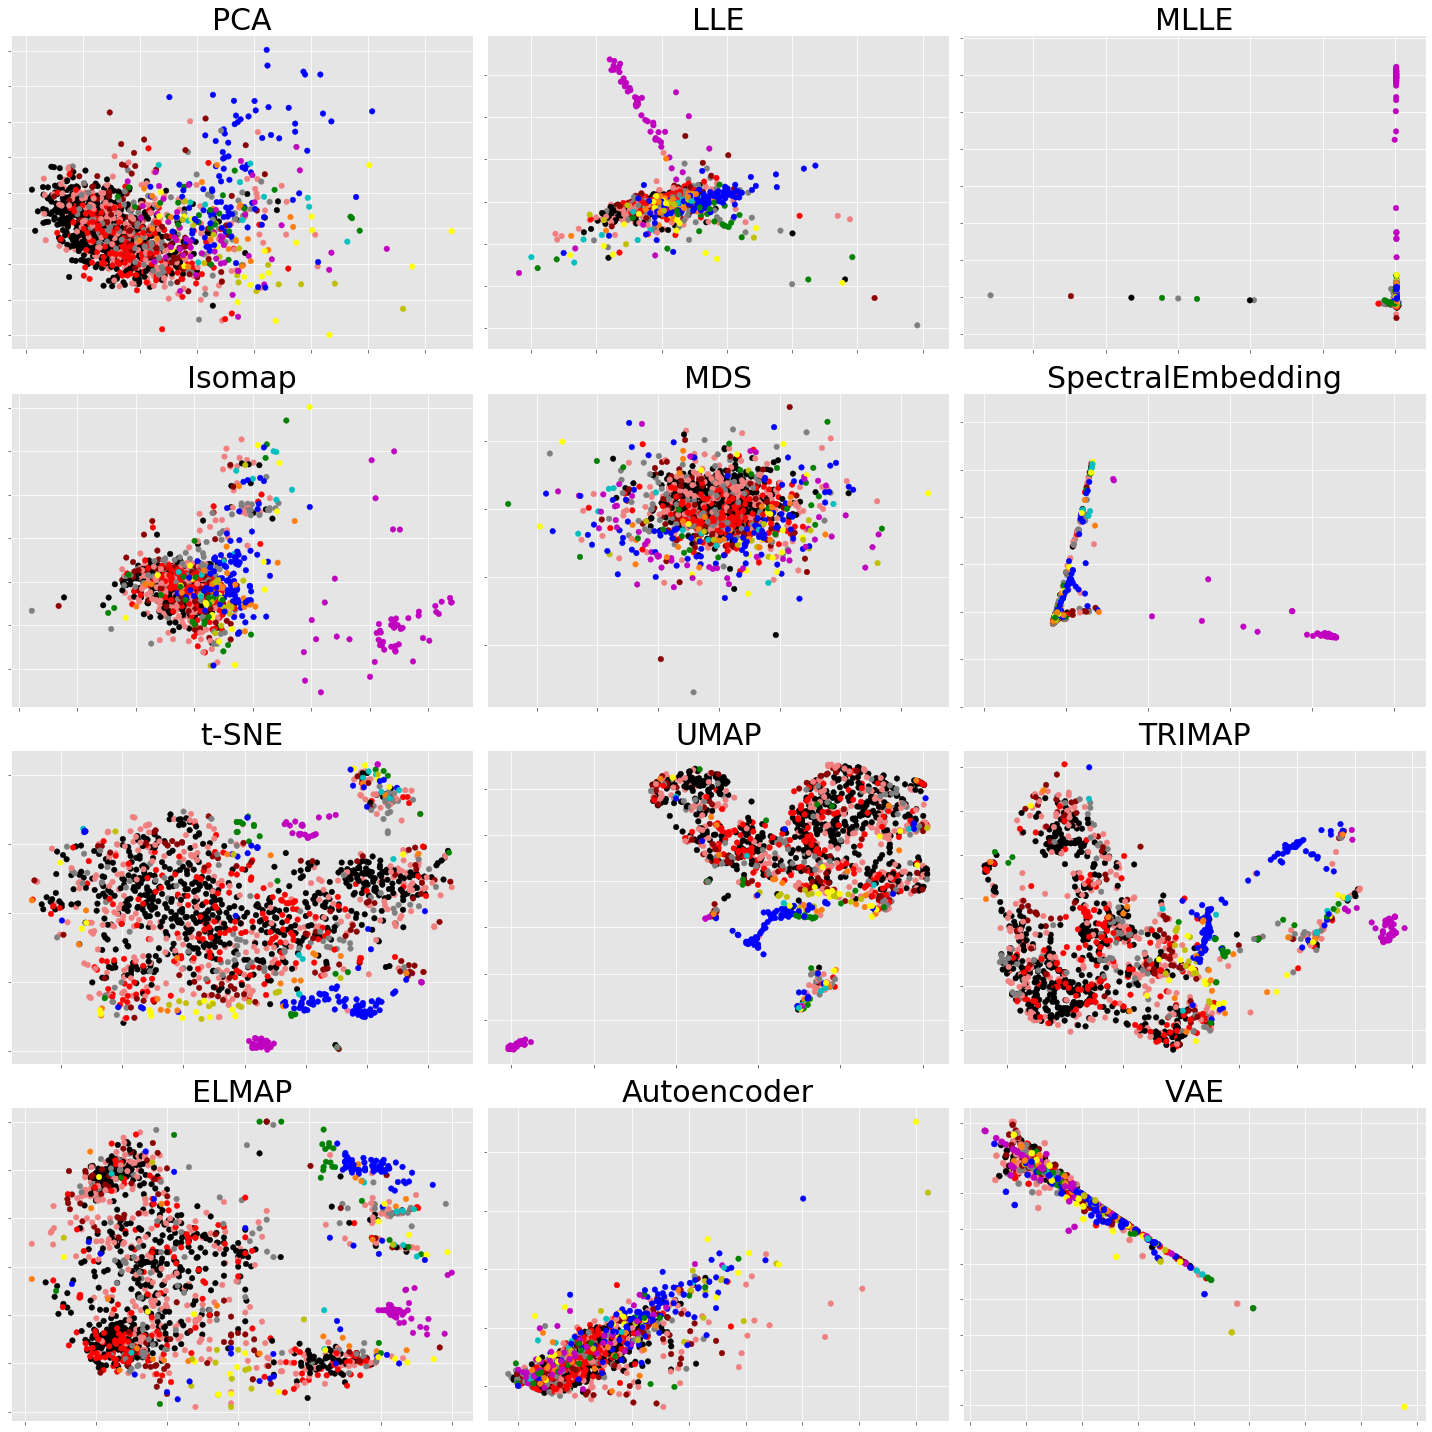

In [34]:
viz_results = apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=[],precomputed_results={},color_map='cool',ColorByFeature='', variable_names=[],
    ElMapFolder=ElMapFolder)

print()

Start computations...
PCA: 1.2e-06 sec
LLE: 3.3e-06 sec
Modified LLE: 1.4e-06 sec
Isomap: 1.9e-06 sec
MDS: 1.7e-06 sec
SpectralEmbedding: 1.7e-06 sec
t-SNE: 1.9e-06 sec
UMAP: 1.7e-06 sec
TRIMAP: 1.7e-06 sec
Autoencoder: 1.7e-06 sec
VAE: 1.9e-06 sec


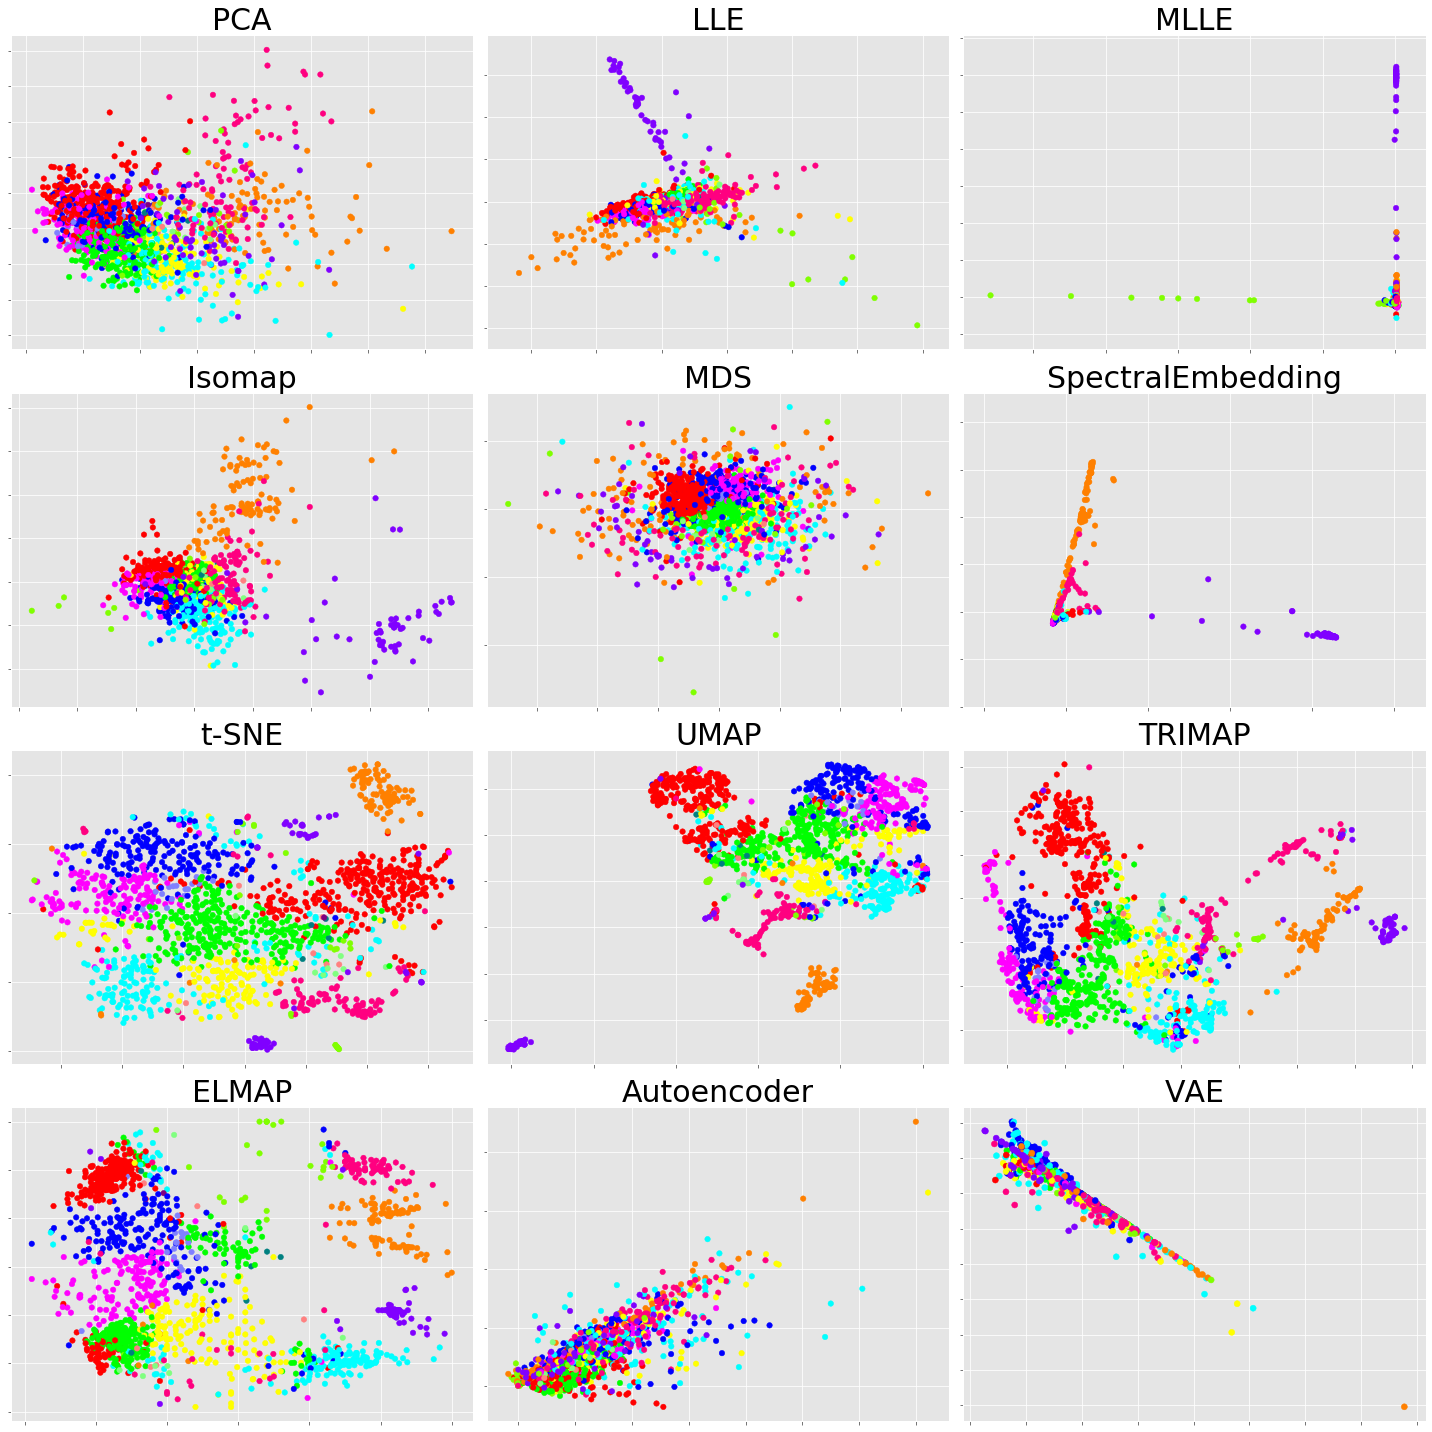

In [38]:
# Now we color by branches of the principal tree

apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=vec_labels_by_branches,precomputed_results=viz_results,color_map='cool',ColorByFeature='', variable_names=[],
    ElMapFolder=ElMapFolder)

print()